# Analysis of CRDC referral and arrest data 


This notebook contains analysis of data from the US Department of Education Civil Rights Data Collection related to arrests and law enforcement referrals of elementary school children in the US.

## Definitions

All definitions here are from the [Master List of Definitions for the 2015-2016 CRDC](https://ocrdata.ed.gov/assets/downloads/CRDC-Definitions-2015-16.pdf).

### Referral to law enforcement

> "...an action by which a student is reported to any law enforcement agency or official, including a school police unit, for an incident that occurs on school grounds, during schoolrelated events, or while taking school transportation, regardless of whether official action is taken. Citations, tickets, court referrals, and school-related arrests are considered referrals to law enforcement."

### School-Related Arrest

> "...an arrest of a student for any activity conducted on school grounds, during offcampus school activities (including while taking school transportation), or due to a referral by any school official. All school-related arrests are considered referrals to law enforcement."

### Children with Disabilities (IDEA)
> "...children with intellectual disabilities; hearing impairment, including deafness; speech or language impairment; visual impairment, including blindness; serious emotional disturbance; orthopedic impairment; autism; traumatic brain injury; developmental delay; other health impairment; specific learning disability; deaf-blindness; or multiple disabilities and who, by reason thereof, receive special education and related services under the Individuals with Disabilities Education Act according to an Individualized Education Program, Individual Family Service Plan, or service plan."

### Students With Disabilities (Section 504 Only)
> "...students with a disability, who receive related aids and services solely under Section 504 of the Rehabilitation Act of 1973, as amended, and not under the Individuals with Disabilities Education Act (IDEA). The "Section 504 Only" column in the survey items always refers to students with disabilities who receive related aids and services under Section 504 of the Rehabilitation Act of 1973, as amended, and not under IDEA."

In [1]:
import os
import re
import geopandas as gpd
import jinja2
import numpy as np
import pandas as pd
import constants


In [2]:
# papermill parameters
DIR = "."
YEAR = 2020
MAX_GRADE = 5


In [3]:
complete_df = pd.read_csv(f"{DIR}/input/crdc-referrals-arrests-cleaned.csv", dtype={0: str, 2: str, 6: str})
df = complete_df.query("year == @YEAR")
df.shape


/tmp/ipykernel_17406/3777368838.py:1: DtypeWarning: Columns (106) have mixed types. Specify dtype option on import or set low_memory=False.
  complete_df = pd.read_csv(f"{DIR}/input/crdc-referrals-arrests-cleaned.csv", dtype={0: str, 2: str, 6: str})


(89301, 140)

## Overall rates

This analysis is limited to the following criteria:
1. students grades MAX_GRADE or younger
2. non-juvenile justice facilities
3. non-alternative schools

It will provide referral and arrest rates per 10,000 children

In [4]:
MULT = 10_000

assign_rates = lambda df: (
    df.assign(
        arrest_rate=lambda df: df.total_arrests / df.total_enrollment * MULT
    ).assign(referral_rate=lambda df: df.total_referrals / df.total_enrollment * MULT)
)

df = df.query("max_grade <= @MAX_GRADE").pipe(assign_rates)

complete_df = complete_df.query("max_grade <= @MAX_GRADE").pipe(assign_rates)

df


,COMBOKEY,LEA_STATE,LEAID,LEA_NAME,SCHID,SCH_NAME,JJ,SCH_STATUS_ALT,SCH_ENR_HI_M,SCH_ENR_HI_F,...,total_arrests_idea,total_arrests_nondis,total_referrals_idea,total_referrals_nondis,total_enrollment_idea,total_enrollment_nondis,grade_category,threshold,arrest_rate,referral_rate
284173,340840006069,NJ,3408400,Lawrence Township Public School District,6069,Eldridge Park School,No,No,32.0,32.0,...,0.0,0.0,0.0,0.0,28.0,205.0,elementary school,16.0,0.0,0.0
284174,340846003018,NJ,3408460,Lebanon Township School District,3018,Valley View School,No,No,11.0,5.0,...,0.0,0.0,0.0,0.0,55.0,261.0,elementary school,16.0,0.0,0.0
284176,340840003164,NJ,3408400,Lawrence Township Public School District,3164,Slackwood Elementary School,No,No,32.0,38.0,...,0.0,0.0,0.0,0.0,15.0,222.0,elementary school,16.0,0.0,0.0
284177,340840003162,NJ,3408400,Lawrence Township Public School District,3162,Lawrenceville Elementary School,No,No,15.0,25.0,...,0.0,0.0,0.0,0.0,63.0,290.0,elementary school,16.0,0.0,0.0
284179,340840003156,NJ,3408400,Lawrence Township Public School District,3156,Ben Franklin Elementary,No,No,33.0,22.0,...,0.0,0.0,0.0,0.0,84.0,369.0,elementary school,16.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329351,362058002602,NY,3620580,New York City Public Schools,2602,Ps 169 Sunset Park,No,No,180.0,191.0,...,NaN,NaN,NaN,NaN,NaN,1212.0,elementary school,16.0,NaN,NaN
329352,362058002396,NY,3620580,New York City Public Schools,2396,Ps 105 Blythebourne (The),No,No,29.0,34.0,...,NaN,NaN,NaN,NaN,NaN,1360.0,elementary school,16.0,NaN,NaN
329353,362058002187,NY,3620580,New York City Public Schools,2187,Ps 42 Benjamin Altman,No,No,23.0,18.0,...,NaN,NaN,NaN,NaN,NaN,541.0,elementary school,16.0,NaN,NaN
329354,362058002119,NY,3620580,New York City Public Schools,2119,Ps 24 Andrew Jackson,No,No,66.0,65.0,...,NaN,NaN,NaN,NaN,NaN,1079.0,elementary school,16.0,NaN,NaN


### National

Nationwide, there are about 5 referrals and 1 arrest for every 10,000 children enrolled in elementary schools.

In [5]:
national_rates = (
    df[["total_enrollment", "total_referrals", "total_arrests"]]
    .sum()
    .to_frame("United States")
    .transpose()
    .pipe(assign_rates)
)

national_rates


,total_enrollment,total_referrals,total_arrests,arrest_rate,referral_rate
United States,15588128.0,3485.0,125.0,0.080189,2.235676


### By state

The rates of referrals and arrests aren't consistent across states. Some states have rates many times the national average.

In [6]:
state_rates = (
    df.reset_index()
    .groupby("LEA_STATE")[["total_enrollment", "total_arrests", "total_referrals"]]
    .sum()
    .pipe(assign_rates)
    .sort_values("arrest_rate", ascending=False)
)

state_rates


,total_enrollment,total_arrests,total_referrals,arrest_rate,referral_rate
LEA_STATE,,,,,
MT,40101.0,4.0,76.0,0.997481,18.952146
NM,100322.0,3.0,11.0,0.299037,1.096469
WI,273106.0,8.0,113.0,0.292927,4.137588
IN,308050.0,8.0,55.0,0.259698,1.785424
OH,492236.0,10.0,326.0,0.203155,6.622839
LA,200177.0,4.0,41.0,0.199823,2.048187
MO,302329.0,6.0,160.0,0.198459,5.292248
KS,155029.0,3.0,20.0,0.193512,1.290081
PA,468105.0,9.0,131.0,0.192265,2.798517


### Individual schools

In [7]:
problem_schools = (
    df.query("total_arrests >= 1")
    .sort_values("total_arrests", ascending=False)
    # geocode schools using NCES school locations file
    # https://nces.ed.gov/programs/edge/geographic/schoollocations
    .pipe(
        lambda df: gpd.read_file(f"{DIR}/input/EDGE_GEOCODE_PUBLICSCH_1718")
        .to_crs("EPSG:4326")
        .merge(
            df.reset_index(), how="right", left_on=["NCESSCH"], right_on=["COMBOKEY"]
        )
    )
    # join nielsen DMAs so I know which to send to which local station
    .pipe(
        lambda df: gpd.sjoin(
            gpd.read_file(f"{DIR}/input/nielsen-dmas.geojson")[
                ["nielsen_dma", "geometry"]
            ].drop_duplicates(),
            df,
            how="right",
            predicate="contains",
        )
    )
    .drop(columns=["index_left"])
    # sjoin counties because people keep asking for them and they're not in the data
    .pipe(
        lambda df: gpd.sjoin(
            gpd.read_file(f"{DIR}/input/counties.geojson")
            .to_crs("EPSG:4326")[["NAME", "geometry"]]
            .rename(columns={"NAME": "county_name"})
            .drop_duplicates(),
            df,
            how="right",
            predicate="contains",
        )
    )[
        [
            "year",
            "full_school_id",
            "SCH_NAME",
            "LEA_NAME",
            "LEA_STATE",
            "county_name",
            "nielsen_dma",
            "max_grade",
            "total_enrollment",
            "total_arrests",
            "total_referrals",
            "arrest_rate",
            "referral_rate",
        ]
    ]
)

problem_schools


,year,full_school_id,SCH_NAME,LEA_NAME,LEA_STATE,county_name,nielsen_dma,max_grade,total_enrollment,total_arrests,total_referrals,arrest_rate,referral_rate
0,2020,390483003201,West Boulevard Elementary School,Boardman Local,OH,Mahoning,"Youngstown, OH",3.0,430.0,10.0,20.0,232.558140,465.116279
1,2020,170141306296,Hedding Grade Sch,Abingdon-Avon Cusd 276,IL,Knox,Davenport-R.Island-Moline,5.0,320.0,6.0,6.0,187.500000,187.500000
2,2020,481524001029,C R Clements/Hollie Parsons El,Copperas Cove Isd,TX,Coryell,Waco-Temple-Bryan,5.0,783.0,6.0,7.0,76.628352,89.399745
3,2020,120081000894,Westside Elementary School,Hernando,FL,Hernando,Tampa-St. Pete,5.0,528.0,5.0,9.0,94.696970,170.454545
4,2020,290564000108,Bourbon Elementary School,Crawford Co. R-I,MO,Crawford,"St. Louis, MO",4.0,325.0,4.0,11.0,123.076923,338.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2020,481527001074,Montclair El,Corpus Christi Isd,TX,Nueces,"Corpus Christi, TX",5.0,285.0,1.0,1.0,35.087719,35.087719
77,2020,481527001065,Kostoryz El,Corpus Christi Isd,TX,Nueces,"Corpus Christi, TX",5.0,380.0,1.0,1.0,26.315789,26.315789
78,2020,422607007404,Evergreen El Sch,Western Wayne Sd,PA,Wayne,Wilkes Barre-Scranton-Hztn,5.0,538.0,1.0,1.0,18.587361,18.587361
79,2020,422454009968,Marlborough El Sch,Upper Perkiomen Sd,PA,Montgomery,"Philadelphia, PA",3.0,322.0,1.0,1.0,31.055901,31.055901


In [8]:
(
    problem_schools.rename(
        # user friendly column names for shared file
        columns={
            "year": "School Year",
            "sch_name": "School Name",
            "lea_name": "District Name",
            "lea_state_name": "State",
            "nielsen_dma": "Nielsen DMA",
            "max_grade": "Maximum grade",
            "arrests": "Total Arrests",
            "referrals": "Total Referrals",
            "arrest_rate": f"Arrest Rate (per {MULT:,} students)",
            "referral_rate": f"Referral Rate (per {MULT:,} students)",
        }
    ).to_excel(
        f"{DIR}/output/high arrest rate schools, grade {MAX_GRADE} and below.xlsx",
        index=False,
    )
)


## By race

### National

In [9]:
def get_race_from_index(df):
    df.index = df.index.map(lambda s: constants.RACE_VALUES[s.split("_")[-1]])
    return df


race_national = (
    (
        df[["total_arrests_bl", "total_arrests_wh", "total_arrests_hi"]]
        .sum()
        .to_frame("total_arrests")
        .pipe(get_race_from_index)
    )
    .join(
        df[["total_referrals_bl", "total_referrals_wh", "total_referrals_hi"]]
        .sum()
        .to_frame("total_referrals")
        .pipe(get_race_from_index)
    )
    .join(
        df[["total_enrollment_bl", "total_enrollment_wh", "total_enrollment_hi"]]
        .sum()
        .to_frame("total_enrollment")
        .pipe(get_race_from_index)
    )
    .pipe(assign_rates)
)

race_national 


,total_arrests,total_referrals,total_enrollment,arrest_rate,referral_rate
Black,21.0,818.0,2371087.0,0.088567,3.449894
White,74.0,1768.0,7066011.0,0.104727,2.502119
Hispanic,20.0,532.0,4313387.0,0.046367,1.233370


#### Non-white students vs white students

In [10]:
race_national_comparison = (
    race_national.transpose()
    .assign(black_vs_white=lambda df: (df.Black - df.White) / df.White)
    .assign(hispanic_vs_white=lambda df: (df.Hispanic - df.White) / df.White)[["black_vs_white", "hispanic_vs_white"]]
    .transpose()
)


### By state

In [11]:
def add_col_level(df, col):
    df = df.copy()
    df.columns = pd.MultiIndex.from_tuples((col, c) for c in df)
    return df


def group_category_state(df, category):
    return (
        df.groupby("LEA_STATE")[
            [f"total_{category}_bl", f"total_{category}_wh", f"total_{category}_hi"]
        ]
        .sum()
        .transpose()
        .pipe(get_race_from_index)
        .transpose()
        .pipe(add_col_level, category)
    )


race_state = df.pipe(
    lambda _df: group_category_state(_df, "arrests")
    .join(group_category_state(_df, "referrals"))
    .join(group_category_state(_df, "enrollment"))
)

race_state['arrest_rate_black'] = (
    race_state['arrests']['Black'] / race_state['enrollment']['Black'] * MULT
)
race_state['arrest_rate_white'] = (
    race_state['arrests']['White'] / race_state['enrollment']['White'] * MULT
)
race_state['arrest_rate_hispanic'] = (
    race_state['arrests']['Hispanic'] / race_state['enrollment']['Hispanic'] * MULT
)

race_state['referral_rate_black'] = (
    race_state['referrals']['Black'] / race_state['enrollment']['Black'] * MULT
)
race_state['referral_rate_white'] = (
    race_state['referrals']['White'] / race_state['enrollment']['White'] * MULT
)
race_state['referral_rate_hispanic'] = (
    race_state['referrals']['Hispanic'] / race_state['enrollment']['Hispanic'] * MULT
)

race_state

arrests                referrals                 enrollment  \
            Black White Hispanic     Black  White Hispanic      Black   
LEA_STATE                                                               
AK            0.0   0.0      0.0       0.0    1.0      0.0      385.0   
AL            2.0   0.0      0.0      10.0    1.0      1.0    84700.0   
AR            0.0   0.0      0.0       3.0    9.0      3.0    29603.0   
AZ            0.0   0.0      0.0       5.0    4.0      9.0     8362.0   
CA            0.0   0.0      0.0       0.0   17.0     19.0    67963.0   
CO            1.0   0.0      1.0       4.0   10.0     18.0    13790.0   
CT            0.0   1.0      0.0       2.0   11.0      9.0    14536.0   
DC            0.0   0.0      0.0       0.0    0.0      0.0    23474.0   
DE            0.0   0.0      0.0       0.0    0.0      0.0    13422.0   
FL            1.0   4.0      1.0     203.0  284.0    132.0   216312.0   
GA            3.0   3.0      1.0      88.0  103.0     17.0   262179.0   
HI            0.0   0.0      0.0       0.0    0.0      0.0      498.0   
IA            0.0   3.0      0.0       5.0   45.0      0.0    11236.0   
ID            0.0   0.0      1.0       0.0   14.0      5.0      819.0   
IL            0.0   7.0      0.0       6.0   22.0      5.0    61566.0   
IN            3.0   3.0      1.0       4.0   40.0      6.0    33430.0   
KS            0.0   2.0      1.0       2.0   13.0      2.0    12024.0   
KY            0.0   0.0      0.0       0.0   23.0      1.0    27187.0   
LA            2.0   2.0      0.0      17.0   19.0      1.0    79455.0   
MA            0.0   0.0      0.0       2.0    7.0      0.0    22614.0   
MD            0.0   2.0      0.0       4.0    4.0      1.0   104263.0   
ME            0.0   0.0      0.0       0.0   30.0      0.0     1966.0   
MI            0.0   0.0      1.0       5.0   44.0      2.0    56658.0   
MN            0.0   0.0      0.0       2.0   20.0      1.0    33211.0   
MO            1.0   5.0      0.0      25.0  121.0      3.0    47468.0   
MS            0.0   0.0      0.0       4.0    5.0      0.0    72699.0   
MT            0.0   4.0      0.0       2.0   57.0      2.0      343.0   
NC            0.0   0.0      0.0      24.0   41.0      4.0   144414.0   
ND            0.0   0.0      0.0       7.0   20.0      5.0     2927.0   
NE            0.0   0.0      0.0       0.0   23.0     11.0     7082.0   
NH            0.0   0.0      0.0       0.0   23.0      2.0     1400.0   
NJ            0.0   0.0      0.0      11.0   25.0      9.0    47720.0   
NM            0.0   1.0      2.0       0.0    3.0      7.0     2235.0   
NV            0.0   2.0      1.0       0.0    5.0      3.0    24012.0   
NY            0.0   0.0      0.0       4.0   14.0      1.0   111945.0   
OH            0.0  10.0      0.0     163.0   95.0     16.0    56984.0   
OK            0.0   1.0      0.0      17.0   49.0     15.0    21425.0   
OR            0.0   0.0      0.0       0.0    6.0      4.0     4357.0   
PA            1.0   8.0      0.0      20.0   91.0      8.0    50377.0   
PR            0.0   0.0      0.0       0.0    0.0      0.0       20.0   
RI            0.0   0.0      0.0       0.0    0.0      0.0     4701.0   
SC            0.0   0.0      0.0      30.0   14.0      6.0    98828.0   
SD            0.0   1.0      0.0      11.0   53.0      9.0     2278.0   
TN            0.0   1.0      0.0      11.0   34.0      7.0    82784.0   
TX            4.0  10.0     10.0      63.0  110.0    134.0   257282.0   
UT            0.0   0.0      0.0       1.0   24.0      6.0     1119.0   
VA            1.0   1.0      0.0      57.0  125.0     28.0   105533.0   
VT            0.0   0.0      0.0       0.0    0.0      0.0      631.0   
WA            0.0   0.0      0.0       1.0    8.0      5.0    18210.0   
WI            2.0   3.0      0.0       5.0   83.0     11.0    20118.0   
WV            0.0   0.0      0.0       0.0    8.0      0.0     4307.0   
WY            0.0   0.0      0.0       0.0   10.0      4.0      235.

In [12]:
(
    (
        race_state.referrals.div(race_state.enrollment)
        .multiply(MULT)
        .assign(black_vs_white=lambda df: (df.Black - df.White) / df.White)
        .assign(hispanic_vs_white=lambda df: (df.Hispanic - df.White) / df.White)[["black_vs_white", "hispanic_vs_white"]]
        .pipe(add_col_level, "referrals")
    ).join(
        race_state.arrests.div(race_state.enrollment)
        .multiply(MULT)
        .assign(black_vs_white=lambda df: (df.Black - df.White) / df.White)
        .assign(hispanic_vs_white=lambda df: (df.Hispanic - df.White) / df.White)[["black_vs_white", "hispanic_vs_white"]]
        .pipe(add_col_level, "arrests")
    ).sort_values(("referrals", "black_vs_white"), ascending=False)
)


referrals                          arrests                  
          black_vs_white hispanic_vs_white black_vs_white hispanic_vs_white
LEA_STATE                                                                  
AL             12.634002          3.817287            inf               NaN
OH              9.706672          0.945553      -1.000000         -1.000000
AZ              5.551363          0.478233            NaN               NaN
CO              3.072342          1.640750            inf               inf
SD              2.606747          0.468718      -1.000000         -1.000000
SC              2.143600          0.737657            NaN               NaN
MT              2.117488         -0.491295      -1.000000         -1.000000
ND              2.068688          1.838827            NaN               NaN
MA              1.120709         -1.000000            NaN               NaN
UT              1.065572          0.134139            NaN               NaN
OK              0.810122         -0.268052      -1.000000         -1.000000
NJ              0.642236         -0.360895            NaN               NaN
PA              0.335604         -0.568043      -0.240375         -1.000000
MD              0.243298         -0.530340      -1.000000         -1.000000
WA              0.230677          0.122878            NaN               NaN
IA              0.221471         -1.000000      -1.000000         -1.000000
IL              0.191608         -0.481648      -1.000000         -1.000000
TX              0.172670         -0.429465      -0.180992         -0.531651
KS              0.160231         -0.609314      -1.000000          0.269729
FL              0.109936         -0.548653      -0.611796         -0.757230
CT              0.059676          0.550545      -1.000000         -1.000000
NC              0.000903         -0.793668            NaN               NaN
LA             -0.006527         -0.770938       0.110352         -1.000000
AR             -0.024367          0.319279            NaN               NaN
MO             -0.100120         -0.761054      -0.128916         -1.000000
VA             -0.105768         -0.423842       0.961036         -1.000000
NY             -0.106671         -0.898449            NaN               NaN
GA             -0.114999         -0.652755       0.035853         -0.298702
TN             -0.195929         -0.144521      -1.000000         -1.000000
IN             -0.383712         -0.203183       5.162878          0.770704
MI             -0.391723         -0.645535            NaN               inf
MS             -0.392487         -1.000000            NaN               NaN
WI             -0.439811         -0.293163       5.199423         -1.000000
MN             -0.466141         -0.697533            NaN               NaN
WV             -1.000000         -1.000000            NaN               NaN
AK             -1.000000         -1.000000            NaN               NaN
OR             -1.000000          0.419402            NaN               NaN
NV             -1.000000         -0.632478      -1.000000         -0.693732
NM             -1.000000         -0.196895      -1.000000         -0.311625
NH             -1.000000         -0.224053            NaN               NaN
NE             -1.000000          0.480470            NaN               NaN
ME             -1.000000         -1.000000            NaN               NaN
KY             -1.000000         -0.651707            NaN               NaN
ID             -1.000000          0.240233            NaN               inf
CA             -1.000000         -0.538560            NaN               NaN
WY             -1.000000          1.174427            NaN               NaN
DC                   NaN               NaN            NaN               NaN
DE                   NaN               NaN            NaN               NaN
HI                   NaN               NaN            NaN               NaN
PR                   NaN               NaN            NaN      

## By disability status

### National

In [13]:
def group_category_national(df, category, name):
    return (
        df[
            [
                f"total_enrollment_{category}",
                f"total_referrals_{category}",
                f"total_arrests_{category}",
            ]
        ]
        .sum()
        .to_frame("United States")
        .transpose()
        .rename(columns=lambda col: col.replace(f"_{category}", ""))
        .pipe(assign_rates)
        .pipe(add_col_level, name)
    )


dis_national = (
    group_category_national(df, "idea", "IDEA")
    .join(group_category_national(df, "nondis", "Without Disabilities"))
    .unstack()
    .droplevel(2)
    .to_frame()
    .reset_index()
    .pivot_table(index="level_0", columns="level_1")
    .droplevel(0, axis=1)[
        [
            "total_arrests",
            "total_referrals",
            "total_enrollment",
            "arrest_rate",
            "referral_rate",
        ]
    ]
)

dis_national.index.name = None
dis_national.columns.name = None

dis_national


,total_arrests,total_referrals,total_enrollment,arrest_rate,referral_rate
IDEA,49.0,1336.0,2189306.0,0.223815,6.102390
Without Disabilities,76.0,2149.0,15588128.0,0.048755,1.378613


### By state

In [14]:
def group_category_state(df, category, name):
    return (
        df.groupby("LEA_STATE")[
            [
                f"total_enrollment_{category}",
                f"total_referrals_{category}",
                f"total_arrests_{category}",
            ]
        ]
        .sum()
        .rename(columns=lambda col: col.replace(f"_{category}", ""))
        .pipe(assign_rates)
        .pipe(add_col_level, name)
    )

dis_state = group_category_state(df, "idea", "IDEA").join(group_category_state(df, "nondis", "Without Disabilities"))
dis_state


IDEA                                            \
          total_enrollment total_referrals total_arrests arrest_rate   
LEA_STATE                                                              
AK                  3259.0             3.0           0.0    0.000000   
AL                 33236.0             5.0           0.0    0.000000   
AR                 20099.0             3.0           0.0    0.000000   
AZ                 18881.0             5.0           0.0    0.000000   
CA                159142.0            27.0           0.0    0.000000   
CO                 37371.0            14.0           0.0    0.000000   
CT                 24123.0             9.0           0.0    0.000000   
DC                  5338.0             0.0           0.0    0.000000   
DE                  6752.0             0.0           0.0    0.000000   
FL                151908.0           293.0           1.0    0.065829   
GA                 91451.0            60.0           0.0    0.000000   
HI                  4081.0             0.0           0.0    0.000000   
IA                 21199.0            31.0           1.0    0.471720   
ID                 10376.0             7.0           1.0    0.963763   
IL                 73341.0            13.0           2.0    0.272699   
IN                 45760.0            22.0           2.0    0.437063   
KS                 26218.0             6.0           3.0    1.144252   
KY                 42915.0             9.0           0.0    0.000000   
LA                 25752.0            13.0           3.0    1.164958   
MA                 49956.0             5.0           0.0    0.000000   
MD                 41575.0             1.0           0.0    0.000000   
ME                  8625.0            13.0           0.0    0.000000   
MI                 57139.0            17.0           0.0    0.000000   
MN                 44692.0            17.0           0.0    0.000000   
MO                 41141.0            46.0           3.0    0.729200   
MS                 21476.0             2.0           0.0    0.000000   
MT                  5240.0            23.0           1.0    1.908397   
NC                 69980.0            20.0           0.0    0.000000   
ND                  5634.0            13.0           0.0    0.000000   
NE                 15825.0            17.0           0.0    0.000000   
NH                  9897.0            13.0           0.0    0.000000   
NJ                 62704.0            14.0           0.0    0.000000   
NM                 16398.0             4.0           2.0    1.219661   
NV                 25417.0             6.0           1.0    0.393437   
NY                135251.0            10.0           0.0    0.000000   
OH                 72358.0            92.0          10.0    1.382017   
OK                 36412.0            35.0           0.0    0.000000   
OR                 23472.0             6.0           0.0    0.000000   
PA                 71813.0            56.0           5.0    0.696253   
PR                 23085.0             0.0           0.0    0.000000   
RI                  8866.0             0.0           0.0    0.000000   
SC                 44638.0            21.0           0.0    0.000000   
SD                  9382.0            58.0           1.0    1.065871   
TN                 47678.0             9.0           2.0    0.419481   
TX                246135.0           106.0           8.0    0.325025   
UT                 11270.0            19.0           0.0    0.000000   
VA                 60188.0           114.0           0.0    0.000000   
VT                  2642.0             0.0           0.0    0.000000   
WA                 53264.0             4.0           0.0    0.000000   
WI                 42193.0            61.0           3.0    0.711018   
WV                 19252.0             4.0           0.0    0.000000   
WY                  4506.0            10.0           0.0    0.000000   

                        Without Disabilities                 

## Trends

<Axes: xlabel='year'>

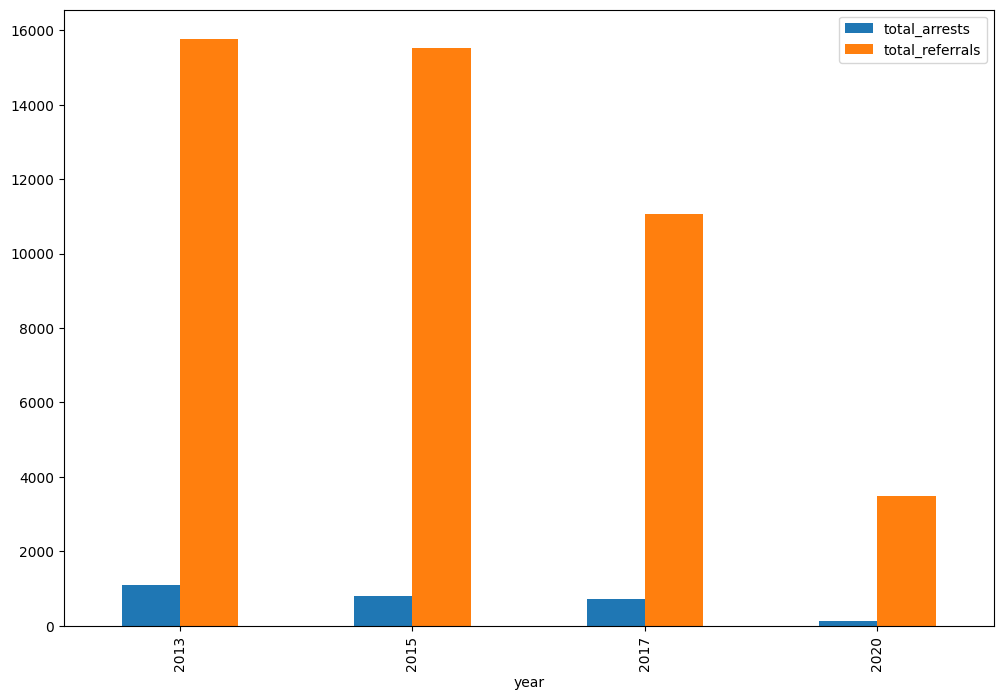

In [15]:
complete_df.groupby("year")[["total_arrests", "total_referrals"]].sum().plot(kind="bar", figsize=(12, 8))

<Axes: title={'center': 'Arrests per 10,000 children'}, xlabel='year'>

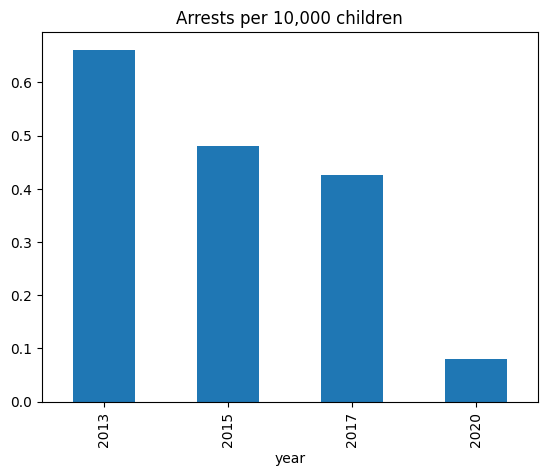

In [16]:
(
    complete_df
    .groupby("year")[["total_arrests", "total_enrollment"]]
    .sum()
    .assign(arrest_rate=lambda df: df
    .total_arrests / df
    .total_enrollment * MULT)
    .arrest_rate
    .plot(kind="bar", title="Arrests per 10,000 children")
)


In [17]:
state_trends = pd.crosstab(
    index=complete_df.LEA_STATE,
    columns=complete_df.year,
    values=complete_df.total_arrests,
    aggfunc="sum",
)

state_trends


year,2013,2015,2017,2020
LEA_STATE,,,,
AK,0.0,0.0,0.0,0.0
AL,2.0,26.0,5.0,2.0
AR,14.0,4.0,3.0,0.0
AZ,18.0,14.0,33.0,0.0
CA,42.0,10.0,28.0,0.0
CO,0.0,2.0,5.0,2.0
CT,12.0,4.0,8.0,1.0
DC,2.0,0.0,0.0,0.0
DE,0.0,2.0,0.0,0.0


In [18]:
df.query("LEA_STATE == 'TX' & total_arrests > 0")[["SCH_NAME", "total_enrollment"] + [c for c in df.columns if "arrest" in c or "referral" in c]].sort_values("total_arrests", ascending=False)

,SCH_NAME,total_enrollment,total_arrests,total_referrals,total_referrals_arrests,total_arrests_am,total_referrals_am,total_arrests_as,total_referrals_as,total_arrests_bl,...,total_arrests_hp,total_referrals_hp,total_arrests_tr,total_referrals_tr,total_arrests_idea,total_arrests_nondis,total_referrals_idea,total_referrals_nondis,arrest_rate,referral_rate
296769,C R Clements/Hollie Parsons El,783.0,6.0,7.0,13.0,1.0,1.0,0.0,0.0,1.0,...,2.0,2.0,0.0,0.0,0.0,6.0,0.0,7.0,76.628352,89.399745
287266,Somerset El,687.0,3.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,43.668122,43.668122
296812,Cooke El,559.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,35.778175,35.778175
296783,City View El,478.0,1.0,10.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,3.0,7.0,20.920502,209.205021
299028,Alvin El,644.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,15.527950,15.527950
298800,Samuel Houston El,414.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,24.154589,24.154589
297991,Noel El,439.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,22.779043,22.779043
297882,El Magnet At Milam El,616.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,16.233766,16.233766
297215,Rj Richey El,463.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,21.598272,21.598272
296894,Northside El,541.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,18.484288,18.484288


## School learning modalities

In [19]:
modality_df = pd.read_csv(
    f"{DIR}/input/School_Learning_Modalities__2020-2021.csv",
    parse_dates=["week"],
    date_format="%m/%d/%Y %I:%M:%S %p"
)
print(modality_df.shape)
modality_df.head()

(429865, 9)


,district_nces_id,district_name,week,learning_modality,operational_schools,student_count,city,state,zip_code
0,100005,Albertville City,2020-09-06,Hybrid,6,5824.0,Albertville,AL,35950
1,100006,Marshall County,2020-09-06,Remote,15,5764.0,Guntersville,AL,35976
2,100007,Hoover City,2020-09-06,Hybrid,18,14061.0,Hoover,AL,35243
3,100008,Madison City,2020-09-06,Remote,11,11695.0,Madison,AL,35758
4,100011,Leeds City,2020-09-06,In Person,4,2076.0,Leeds,AL,35094


In [20]:
print(modality_df.state.nunique())
modality_df.state.unique()


52


array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'BI'], dtype=object)

In [21]:
modality_df.learning_modality.unique()

array(['Hybrid', 'Remote', 'In Person'], dtype=object)

In [22]:
weekly_modality_df = (
    modality_df.pivot_table(
    index="week",
    columns=["learning_modality", "state"],
    values="operational_schools",
    aggfunc="sum",
    )
    .assign(
        total=lambda x: x.sum(axis=1),
        pct_in_person=lambda x: x["In Person"].sum(axis=1) / x["total"],
        pct_hybrid=lambda x: x["Hybrid"].sum(axis=1) / x["total"],
        pct_remote=lambda x: x["Remote"].sum(axis=1) / x["total"],
        total_pct=lambda x: x.pct_in_person + x.pct_hybrid + x.pct_remote,
    )
)
weekly_modality_df


learning_modality Hybrid                                                    \
state                 AK      AL     AR     AZ   BI      CA      CO     CT   
week                                                                         
2020-09-06         133.0   927.0  306.0  556.0  1.0   746.0   971.0  705.0   
2020-09-13         124.0  1005.0  319.0  658.0  3.0   763.0   964.0  712.0   
2020-09-20         125.0  1037.0  325.0  668.0  3.0   761.0  1057.0  711.0   
2020-09-27         125.0   977.0  329.0  592.0  4.0   822.0  1054.0  705.0   
2020-10-04         119.0  1063.0  333.0  599.0  4.0   938.0   935.0  676.0   
2020-10-11         119.0  1076.0  333.0  652.0  4.0  1264.0  1025.0  661.0   
2020-10-18         119.0   891.0  301.0  672.0  4.0  1747.0   966.0  648.0   
2020-10-25         118.0   907.0  330.0  724.0  4.0  2075.0   941.0  658.0   
2020-11-01         124.0   824.0  331.0  744.0  4.0  1845.0   941.0  668.0   
2020-11-08         124.0   832.0  326.0  734.0  4.0  1695.0   939.0  680.0   
2020-11-15         124.0   911.0  350.0  673.0  4.0  1840.0   802.0  664.0   
2020-11-22         124.0   903.0  322.0  670.0  2.0  1841.0   802.0  664.0   
2020-11-29         124.0   899.0  320.0  626.0  2.0  1779.0   586.0  439.0   
2020-12-06         124.0   973.0  311.0  613.0  1.0  1659.0   615.0  526.0   
2020-12-13         124.0   870.0  323.0  609.0  1.0  1564.0   560.0  558.0   
2020-12-20         124.0   835.0  328.0  605.0  1.0  1753.0   433.0  558.0   
2020-12-27         124.0   812.0  326.0  607.0  1.0  1777.0   402.0  555.0   
2021-01-03         104.0   720.0  304.0  262.0  1.0  1270.0   535.0  517.0   
2021-01-10         112.0   774.0  312.0  255.0  1.0  1346.0   615.0  617.0   
2021-01-17         218.0   326.0  305.0  451.0  1.0  1517.0   880.0  742.0   
2021-01-24         212.0   346.0  303.0  536.0  1.0  1653.0  1114.0  743.0   
2021-01-31         176.0   352.0  295.0  501.0  1.0  1924.0  1106.0  717.0   
2021-02-07          77.0   370.0  283.0  501.0  1.0  2074.0  1223.0  730.0   
2021-02-14          77.0   335.0  246.0  505.0  1.0  2154.0  1293.0  718.0   
2021-02-21         200.0   426.0  252.0  540.0  1.0  2410.0  1261.0  726.0   
2021-02-28         200.0   415.0  284.0  481.0  1.0  2640.0  1243.0  696.0   
2021-03-07         203.0   460.0  295.0  526.0  1.0  3072.0  1266.0  655.0   
2021-03-14         203.0   467.0  271.0  493.0  1.0  3450.0  1170.0  649.0   
2021-03-21         203.0   467.0  280.0  523.0  1.0  3893.0  1067.0  615.0   
2021-03-28         203.0   470.0  290.0  708.0  1.0  4260.0  1050.0  598.0   
2021-04-04         203.0   480.0  296.0  706.0  1.0  4566.0  1049.0  569.0   
2021-04-11         203.0   458.0  298.0  704.0  1.0  6549.0  1049.0  545.0   
2021-04-18         203.0   458.0  298.0  703.0  1.0  6662.0  1049.0  462.0   
2021-04-25         199.0   457.0  298.0  705.0  1.0  6733.0  1041.0  466.0   
2021-05-02         199.0   457.0  297.0  706.0  1.0  6708.0  1044.0  412.0   
2021-05-09         199.0   457.0  286.0  709.0  1.0  6611.0  1044.0  324.0   
2021-05-16         199.0   454.0  279.0  708.0  1.0  6402.0  1047.0  243.0   
2021-05-23         199.0   454.0  271.0  704.0  1.0  5958.0  1047.0  224.0   
2021-05-30         199.0   454.0  262.0  694.0  1.0  5929.0  1045.0  240.0   

learning_modality                ... Remote                              \
state                 DC     DE  ...     VT      WA     WI     WV    WY   
week                             ...                                      
2020-09-06           NaN   79.0  ...    5.0  2014.0  429.0   65.0   5.0   
2020-09-13           NaN   97.0  ...    5.0  2014.0  437.0   65.0   5.0   
2020-09-20           NaN   70.0  ...    5.0  2014.0  445.0  134.0   5.0   
2020-09-27           NaN   70.0  ...    5.0  2014.0  288.0  119.0   5.0   
2020-10-04           NaN   77.0  ...    NaN  1553.0  515.0  119.0   5.0   
2020-10-11           NaN   77.0  ...   11.0  1547.0  524.0   54.0   5.0   
2020-10-18           NaN  148.0  ...   11.0  154

<Axes: xlabel='week'>

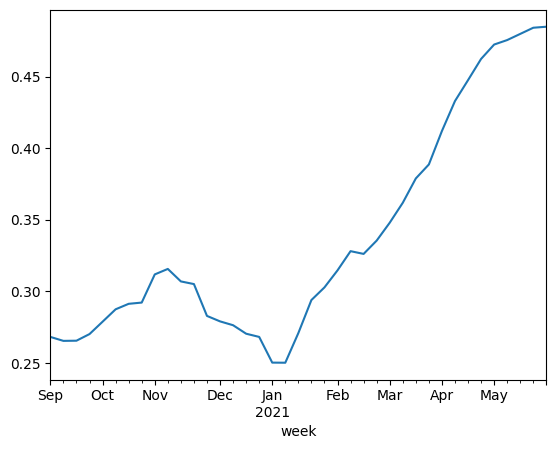

In [23]:
weekly_modality_df.pct_in_person.plot()


In [24]:
pivot_table = lambda x: x.pivot_table(
    index="week",
    columns="state",
    values="operational_schools",
    aggfunc="sum",
)

# calculate the percent in person for each state
state_pct_in_person = (
    modality_df.query("learning_modality == 'In Person'").pipe(pivot_table)
    / modality_df.pipe(pivot_table)
)

state_pct_in_person_or_hybrid = (
    modality_df.query("learning_modality in ['In Person', 'Hybrid']").pipe(pivot_table)
    / modality_df.pipe(pivot_table)
)

state_pct_in_person


state,AK,AL,AR,AZ,BI,CA,CO,CT,DC,DE,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
week,,,,,,,,,,,,,,,,,,,,,
2020-09-06,0.382413,0.064758,0.648680,0.084778,NaN,0.019334,0.167406,0.131461,NaN,NaN,...,0.630657,0.139055,0.673451,0.255521,0.015400,0.026490,0.009532,0.530162,0.058565,0.555556
2020-09-13,0.400818,0.056578,0.639140,0.088366,NaN,0.018630,0.175854,0.133259,NaN,NaN,...,0.662319,0.091156,0.671899,0.248950,0.015400,0.026490,0.009524,0.448141,0.067153,0.594203
2020-09-20,0.400000,0.066712,0.633296,0.089937,NaN,0.013299,0.180220,0.137277,NaN,NaN,...,0.663768,0.080176,0.670920,0.248950,0.015400,0.026490,0.009520,0.393083,0.052555,0.611446
2020-09-27,0.402439,0.094118,0.630580,0.088070,NaN,0.012603,0.180220,0.146830,NaN,NaN,...,0.546377,0.195122,0.676671,0.155299,0.015415,0.025806,0.009508,0.366667,0.048175,0.617391
2020-10-04,0.404858,0.108844,0.629301,0.088861,NaN,0.015775,0.216524,0.167964,NaN,NaN,...,0.511834,0.189160,0.676838,0.112395,0.015415,0.070968,0.010762,0.454821,0.048175,0.617391
2020-10-11,0.404858,0.083503,0.629301,0.144110,NaN,0.028698,0.209863,0.182927,NaN,NaN,...,0.478955,0.191024,0.679128,0.173319,0.015431,0.045161,0.011189,0.412391,0.054015,0.649123
2020-10-18,0.406061,0.171429,0.653272,0.146818,NaN,0.030888,0.296661,0.186947,NaN,NaN,...,0.487663,0.190398,0.679741,0.089286,0.015415,0.046358,0.011180,0.372217,0.061314,0.651163
2020-10-25,0.409736,0.173706,0.633038,0.134810,NaN,0.023695,0.305205,0.192265,NaN,NaN,...,0.489884,0.188751,0.679403,0.081568,0.015415,0.046358,0.011162,0.372826,0.042336,0.692082
2020-11-01,0.440162,0.184605,0.632337,0.110969,NaN,0.028302,0.306134,0.181717,NaN,NaN,...,0.479769,0.254732,0.708867,0.471639,0.003012,0.088050,0.010404,0.336240,0.062774,0.770349


In [25]:
state_avg = (
    # state_pct_in_person
    state_pct_in_person_or_hybrid
    .mean()
    .sort_values(ascending=False)
    .to_frame("avg_weekly_schools_in_person_or_hybrid")
    .dropna()
)
state_avg


,avg_weekly_schools_in_person_or_hybrid
state,
HI,1.000000
AR,0.984388
ME,0.983627
ND,0.981980
WY,0.980922
FL,0.979311
UT,0.965347
SD,0.964050
ID,0.962907


In [29]:
rates_averages = state_rates.join(state_avg)
(
    rates_averages
    .plot(
        kind="scatter",
        x="avg_weekly_schools_in_person_or_hybrid",
        y="referral_rate",
        backend="hvplot",
        hover_cols=["LEA_STATE", "total_enrollment", "total_referrals"],
        width=800,
        height=600,
    )
)

:Scatter   [avg_weekly_schools_in_person_or_hybrid]   (referral_rate,LEA_STATE,total_enrollment,total_referrals)

In [31]:
(
    rates_averages
    .plot(
        kind="scatter",
        x="avg_weekly_schools_in_person_or_hybrid",
        y="arrest_rate",
        backend="hvplot",
        hover_cols=["LEA_STATE", "total_enrollment", "total_referrals"],
        width=800,
        height=600,
    )
)

:Scatter   [avg_weekly_schools_in_person_or_hybrid]   (arrest_rate,LEA_STATE,total_enrollment,total_referrals)

## Output

### Generate reports for local stations


In [27]:
MARKETS = {
    "New York": {"state": "NY"},
    "Los Angeles": {"state": "CA"},
    "Chicago": {"state": "IL"},
    "DFW": {"state": "TX"},
    "Philadelphia": {"state": "PA"},
    "Pittsburgh": {"state": "PA"},
    "Boston": {"state": "MA"},
    "Miami": {"state": "FL"},
    "Sacramento": {"state": "CA"},
    "Bay Area": {"state": "CA"},
    "Detroit": {"state": "MI"},
    "Colorado": {"state": "CO"},
    "Baltimore": {"state": "MD"},
    "Minnesota": {"state": "MN"},
}

env = jinja2.Environment(
    loader=jinja2.FileSystemLoader(f"{DIR}/hand/"), undefined=jinja2.StrictUndefined
)
template = env.get_template("report_template.md")
# overall national rate series
nrs = national_rates.iloc[0]

path = f"{DIR}/output/reports"
if not os.path.exists(path):
    os.makedirs(path)

for market_name, market_info in MARKETS.items():
    content = template.render(
        market_name=market_name,
        state=market_info["state"],
        national_total_arrests=nrs.total_arrests,
        national_total_referrals=nrs.total_referrals,
        pct_arrested_1_in_x=round(nrs.total_referrals / nrs.total_arrests),
        arrest_rate_black_vs_white=round(
            race_national.query("index == 'Black'").iloc[0].arrest_rate
            / race_national.query("index == 'White'").iloc[0].arrest_rate,
            1,
        ),
        arrest_rate_idea_vs_nondis=round(
            dis_national.query("index == 'IDEA'").iloc[0].arrest_rate
            / dis_national.query("index == 'Without Disabilities'").iloc[0].arrest_rate,
            1,
        ),
        state_total_arrests=state_rates.query("index == @market_info['state']")
        .iloc[0]
        .total_arrests,
        state_total_referrals=state_rates.query("index == @market_info['state']")
        .iloc[0]
        .total_referrals,
        state_total_arrests_white=race_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .arrests.White,
        state_total_arrests_black=race_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .arrests.Black,
        state_total_arrests_hispanic=race_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .arrests.Hispanic,
        state_total_referrals_white=race_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .referrals.White,
        state_total_referrals_black=race_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .referrals.Black,
        state_total_referrals_hispanic=race_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .referrals.Hispanic,
        state_total_arrests_idea=dis_state.query("index == @market_info['state']")
        .iloc[0]
        .IDEA.total_arrests,
        state_total_referrals_idea=dis_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]
        .IDEA.total_referrals,
        state_total_arrests_nondis=dis_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]["Without Disabilities"]
        .total_arrests,
        state_total_referrals_nondis=dis_state.query(
            "index == @market_info['state']"
        )
        .iloc[0]["Without Disabilities"]
        .total_referrals,
    )

    with open(
        f"{DIR}/output/reports/crdc-data-g{MAX_GRADE}-{market_name.lower().replace(' ', '-')}-year-beginning-{YEAR}.md",
        "w",
        encoding="utf-8",
    ) as f:
        f.write(content)


### Write data files to excel

In [28]:
with pd.ExcelWriter(
    f"{DIR}/output/crdc-le-analysis-g{MAX_GRADE}-and-below-year-beginning-{YEAR}.xlsx"
) as writer:
    national_rates.to_excel(writer, sheet_name="Overall - National")
    state_rates.to_excel(writer, sheet_name="Overall - By State")
    race_national.to_excel(writer, sheet_name="Race - National")
    race_state.to_excel(writer, sheet_name="Race - By State")
    dis_national.to_excel(writer, sheet_name="Disability - National")
    dis_state.to_excel(writer, sheet_name="Disability - By State")
    problem_schools.to_excel(writer, sheet_name="Individual Schools With Arrests")
